# Spoticore *Stage 2*

We improve on stage 1.

We start with the improvement in the intialization of the model parameters to bring down the high loss observed during the first few iterations of the training loop.

Based on [Bengio et al., 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Contents

1. **Setup & Data Processing** - Load constants, data readers, and vocabulary builders
2. **Model Architecture** - MLP implementation with embedding, hidden, and output layers
3. **Training** - Forward/backward passes and optimization
4. **Evaluation** - Development set validation
5. **Text Generation** - Sample from the trained model
6. **Experiments** - Learning rate tuning and architecture exploration

## Model Overview

- **Input**: Fixed-length character sequences (context windows)
- **Architecture**: Embedding → Hidden Layer (tanh) → Output Layer (softmax)
- **Task**: Predict the next character given context
- **Training**: Cross-entropy loss with mini-batch SGD


## 1. Constants


In [19]:
from typing import Final

In [20]:
# Random Seed.
SAMPLE_SEED: Final[int] = 534150593

# Data Processing.
LYRICS_COLUMN: Final[str] = "text"
DEFAULT_CSV_PATH: Final[str] = "spotify_lyrics.csv"

# Model Architecture - MLP.
BLOCK_SIZE: int = 3  # Context window size (number of characters).

# Training Hyperparameters.
LEARNING_RATE: float = 0.1
REGULARIZATION_FACTOR: float = 0.001
EMBEDDING_DIM: int = 10  # Dimension of character embeddings.
HIDDEN_LAYER_SIZE: int = 100  # Number of neurons in the hidden layer.
BATCH_SIZE: int = 32  # Number of inputs per training iteration

# Kaiming init gains for different non linearity functions
GAIN_TANH = 5 / 3

## 2. Data Reader


In [21]:
import csv
import string

In [22]:
def read_all_lyrics(csv_path: str = DEFAULT_CSV_PATH) -> list[str]:
    """
    Process the Spotify lyrics CSV file and extract all lyrics text.

    Args:
        csv_path: Path to the CSV file. Defaults to "spotify_lyrics.csv".

    Returns:
        List of lyrics text strings, one per song.
    """
    lyrics_list = []

    with open(csv_path, "r", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile)

        for row in reader:
            # Extract the lyrics text from the 'text' column.
            lyrics = row.get(LYRICS_COLUMN, "").strip().lower()
            if lyrics:  # Only add non-empty lyrics.
                lyrics_list.append(lyrics)

    return lyrics_list


def read_all_unique_words(csv_path: str = DEFAULT_CSV_PATH) -> list[str]:
    """
    Process the Spotify lyrics CSV file and extract all unique individual words.

    Punctuation is removed from words before adding them to the vocabulary.

    Args:
        csv_path: Path to the CSV file. Defaults to "spotify_lyrics.csv".

    Returns:
        Sorted list of unique words from all lyrics, with punctuation removed.
    """
    words_list = []
    # Create a translation table that replaces punctuation with spaces.
    translator = str.maketrans({punct: " " for punct in string.punctuation})

    with open(csv_path, "r", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            lyrics = row.get(LYRICS_COLUMN, "").strip().lower()
            if lyrics:
                # Replace punctuation with spaces before splitting.
                sanitized_lyrics = lyrics.translate(translator)
                # Filter out empty strings created by consecutive spaces.
                words_list.extend([word for word in sanitized_lyrics.split() if word])

    return sorted(set(words_list))

## 3. MLP Model


In [23]:
import torch
import torch.nn.functional as F
from dataclasses import dataclass

In [24]:
@dataclass(frozen=True)
class Parameters:
    """
    Container for MLP network parameters.

    Holds all trainable weights and biases for the three-layer network:
    - Embedding layer (C)
    - Hidden layer (W1, b1)
    - Batch normalization (bn_gain, bn_bias)
    - Output layer (W2, b2)

    Attributes:
        C: Embedding matrix of shape (vocab_size, embedding_dim).
           Maps character indices to dense vector representations.
        W1: Hidden layer weight matrix of shape (block_size * embedding_dim, hidden_size).
        b1: Hidden layer bias vector of shape (hidden_size,).
        W2: Output layer weight matrix of shape (hidden_size, vocab_size).
        b2: Output layer bias vector of shape (vocab_size,).
        bn_gain: Batch normalization scale parameter of shape (hidden_size,).
        bn_bias: Batch normalization shift parameter of shape (hidden_size,).
    """

    C: torch.Tensor
    W1: torch.Tensor
    W2: torch.Tensor
    b1: torch.Tensor
    b2: torch.Tensor

    # batchNorm params
    bn_gain: torch.Tensor
    bn_bias: torch.Tensor

    # for histogram visualization of tanh behaviour on hidden layer outputs
    pre_acts: torch.Tensor = torch.tensor(0.0)
    h: torch.Tensor = torch.tensor(0.0)

    @property
    def parameters(self) -> tuple[torch.Tensor, ...]:
        """Return all parameters as a tuple for gradient operations."""
        return (self.C, self.W1, self.W2, self.b1, self.b2)

    def update_pre_acts(self, new_acts: torch.Tensor) -> None:
        object.__setattr__(self, "pre_acts", new_acts)

    def update_h(self, new_h: torch.Tensor) -> None:
        object.__setattr__(self, "h", new_h)

In [25]:
def build_vocab_from_words():
    """
    Build vocabulary mappings from unique words.

    Reads all unique words from the CSV file and creates string-to-index (stoi)
    and index-to-string (itos) mappings for all characters found in the words.
    The period character (.) is assigned index 0.

    Returns:
        tuple: A tuple containing:
            - stoi (dict[str, int]): Mapping from character to index.
            - itos (dict[int, str]): Mapping from index to character.
            - words (list[str]): List of all unique words.
    """
    words = read_all_unique_words()
    chars = sorted(list(set(".".join(words))))
    stoi = {char: i for i, char in enumerate(chars)}
    stoi["."] = 0
    itos = {i: char for i, char in enumerate(stoi)}

    return stoi, itos, words

In [26]:
def build_dataset(
    words: list[str],
    stoi: dict[str, int],
    block_size: int = BLOCK_SIZE,
) -> tuple[torch.Tensor, torch.Tensor, int]:
    """
        Build training dataset from words using character-level context windows.
    plt.figure(figsize=(50,30))
    plt.imshow(params.h.abs() > 0.99, cmap ="Accent", interpolation="nearest")
    plt.title("Tanh() saturation in hidden layer")
    plt.xlabel("Hidden neuron index (column)")
    plt.ylabel("Input sample index (row)")
    plt.colorbar(label="Saturated (|tanh(x)| > 0.99)")
        Creates input-output pairs where each input is a context window of characters
        and the output is the next character to predict. Uses a sliding window approach
        with a fixed context length (block_size).

        Args:
            words: List of words to build the dataset from.
            stoi: Mapping from character to index for converting characters to tensor inputs.
            block_size: Number of characters in the context window. Defaults to 3.

        Returns:
            tuple: A tuple containing:
                - X (torch.Tensor): Input tensor of shape (n_samples, block_size) with context windows.
                - Y (torch.Tensor): Output tensor of shape (n_samples,) with target character indices.
                - block_size (int): The context window size used.
    """
    # Input and corresponding output (labels) matrices.
    X, Y = [], []

    for word in words:
        prev_char_idxs = [0] * block_size
        for char in word + ".":
            next_char_idx = stoi[char]
            X.append(prev_char_idxs)
            Y.append(next_char_idx)
            prev_char_idxs = prev_char_idxs[1:] + [next_char_idx]

    return torch.tensor(X), torch.tensor(Y), block_size

### Dataset Splitting

Split the data into three disjoint sets:
- **Training (80%)**: Used to update model weights via gradient descent
- **Development/Validation (10%)**: Used to tune hyperparameters and monitor overfitting
- **Testing (10%)**: Held out for final performance evaluation (used only once)

In [27]:
import random

In [28]:
@dataclass(frozen=True)
class SplitData:
    """
    Container for train/dev/test dataset splits.

    Holds all data needed for training, validation, and testing with
    convenient property accessors for each split.

    Attributes:
        vocab_size: Number of unique characters in the vocabulary.
        X_train: Training input tensor of shape (n_train_samples, block_size).
        X_dev: Development input tensor of shape (n_dev_samples, block_size).
        X_test: Test input tensor of shape (n_test_samples, block_size).
        Y_train: Training target tensor of shape (n_train_samples,).
        Y_dev: Development target tensor of shape (n_dev_samples,).
        Y_test: Test target tensor of shape (n_test_samples,).
        ctxlen_train: Context window size for training (should equal BLOCK_SIZE).
        ctxlen_dev: Context window size for development (should equal BLOCK_SIZE).
        ctxlen_test: Context window size for testing (should equal BLOCK_SIZE).
    """

    vocab_size: int = 0

    X_train: torch.Tensor = torch.tensor(0)
    X_dev: torch.Tensor = torch.tensor(0)
    X_test: torch.Tensor = torch.tensor(0)

    Y_train: torch.Tensor = torch.tensor(0)
    Y_dev: torch.Tensor = torch.tensor(0)
    Y_test: torch.Tensor = torch.tensor(0)

    ctxlen_train: int = 0
    ctxlen_dev: int = 0
    ctxlen_test: int = 0

    @property
    def train_data(self) -> tuple[torch.Tensor, torch.Tensor, int]:
        """Return (X_train, Y_train, context_length) tuple."""
        return (self.X_train, self.Y_train, self.ctxlen_train)

    @property
    def dev_data(self) -> tuple[torch.Tensor, torch.Tensor, int]:
        """Return (X_dev, Y_dev, context_length) tuple."""
        return (self.X_dev, self.Y_dev, self.ctxlen_dev)

    @property
    def test_data(self) -> tuple[torch.Tensor, torch.Tensor, int]:
        """Return (X_test, Y_test, context_length) tuple."""
        return (self.X_test, self.Y_test, self.ctxlen_test)

In [29]:
def split_training_dataset():
    """
    Split the dataset into training, development, and test sets.

    Loads all unique words from the vocabulary, shuffles them deterministically,
    and splits into three disjoint sets:
    - Training (80%): For optimizing model weights via gradient descent
    - Development (10%): For tuning hyperparameters and detecting overfitting
    - Testing (10%): For final unbiased performance evaluation

    Returns:
        SplitData: Object containing:
            - vocab_size: Number of unique characters
            - X_train, Y_train: Training input/output tensors
            - X_dev, Y_dev: Development input/output tensors
            - X_test, Y_test: Testing input/output tensors
            - ctxlen_train/dev/test: Context window sizes (should all be equal)

    Note:
        Uses fixed random seed (42) for reproducible splits across runs.
        Each word is expanded into multiple (context, next_char) training examples.
    """
    random.seed(42)

    stoi, _, words = build_vocab_from_words()

    random.shuffle(words)

    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))

    X_train, Y_train, train_ctxlen = build_dataset(words[:n1], stoi)
    X_dev, Y_dev, dev_ctxlen = build_dataset(words[n1:n2], stoi)
    X_test, Y_test, test_ctxlen = build_dataset(words[n2:], stoi)

    return SplitData(
        len(stoi),
        X_train,
        X_dev,
        X_test,
        Y_train,
        Y_dev,
        Y_test,
        train_ctxlen,
        dev_ctxlen,
        test_ctxlen,
    )

### Normal distribution sampling

torch.randn() samples from a normal (guassian) distribution with a mean of 0 and a variance of 1. Standard deviation =  sqrt(variance) so standard deviation of this distribution is also 1.

The number that we multiple the sample vector/matrix becomes the standard deviation of the output vector/matrix.

In [30]:
# std closer to 1
torch.randn(10_000).std()

tensor(0.9993)

In [31]:
# std closer to 0.2
(torch.randn(10_000) * 0.2).std()

tensor(0.1983)

Variance properties:

1. If `X` and `Y` are independent random variables, the variance of their sum is the sum of their variances:

   Var(`X` + `Y`) = Var(`X`) + Var(`Y`)


2. For the product of two independent random variables with **zero** mean:

   Var(`W`·`X`) = Var(`W`) · Var(`X`)

   This rule is used when calculating Var(wᵢxᵢ) and holds when `W` and `X` are independent with E[W]=0 and E[X]=0.


These two rules are needed for understanding how variance propagates through neural network layers in the explanation below.



### Kaiming Initialization


A _signal_ refers to the output of a layer's activation function.

The goal of kaiming Init is to compute a standard deviation for the initial parameters to ensure that the variance of the activations remains consistent (ideally ≈1) as the signal passes through multiple hidden layers, both during the forward and backward passes. This sd is summarized in [He et al. (2015)](https://arxiv.org/pdf/1502.01852):

$$\text{Gain} \times \frac{1}{\sqrt{\text{fan\_in}}}$$

### Understanding _1/√fan_in_

When computing a pre-activation in a layer:

`s = w₁x₁ + w₂x₂ + ... + wₙxₙ`

we sum **n = fan_in** terms. If we assume weights and inputs are independent with zero mean:

`Var(s) = fan_in × Var(W) × Var(X)`

__Note__:

If `fan_in = 100` and each weight/input has variance 1, then `Var(s) = 100`! The variance **explodes** proportionally to fan_in!

We want `Var(s) = Var(X)` (variance stays stable). Setting up the equation:

`fan_in × Var(W) × Var(X) = Var(X)` → `Var(W) = 1/fan_in`

Since standard deviation = √variance:

`std(W) = 1/√fan_in`

**Intuition**: 

More inputs = more terms being summed = larger sum. To counteract this, we make each weight _smaller_ in proportion to √fan_in. The square root appears because std is √variance.

### Understanding _Gain_

The _Gain_ is a multiplier that compensates for the non-linearity's squeezing effect (e.g., `tanh` compresses outputs toward zero). See the research paper for more information.

### Conclusion

This sd prevents the signal from either vanishing (shrinking to zero) or exploding (growing without bound).

If we keep the variance of the pre-activations (s) stable and close to 1 (which means the standard deviation is also ≈1), we ensure that most values fall within ±1 or ±2 standard deviations of the mean. For the `tanh` function, the non-saturated region is exactly around ±1 to ±2.

Therefore, by stabilizing the variance to 1, we naturally distribute the inputs into the active, non-saturated region of the non-linearity `tanh`, and maximize the gradient flow during backpropagation.


In [32]:
def initialize_parameters(
    vocab_size: int, block_size: int, generator: torch.Generator | None = None
) -> Parameters:
    """
    Initialize network parameters with random values.

    Uses standard normal initialization for now. Each input to the network
    is flattened into a row vector of size (BLOCK_SIZE * EMBEDDING_DIM).

    Args:
        vocab_size: Size of the vocabulary (number of unique characters).
        block_size: Number of characters in the context window.
        generator: Optional random number generator for reproducible initialization.

    Returns:
        Parameters: Container with initialized embedding, weight, and bias tensors.

    Note:
        Weight initialization strategy differs by layer:

        - Hidden layers (W1, b1): Uses small random values to break symmetry.
          If all weights were identical (e.g., zeros), all neurons would compute
          identical outputs and receive identical gradients, causing them to
          update identically and never specialize. Random initialization ensures
          neurons can learn different features.

        - Output layer (W2, b2): Uses very small values (W2 *= 0.01, b2 = 0)
          to avoid "confidently wrong" predictions. If W2 is sampled from a
          standard normal distribution, the logits can take extreme values,
          producing very confident (but wrong) softmax outputs. This causes high
          initial cross-entropy loss and potentially unstable gradients. Small W2
          values keep initial logits near zero, yielding roughly uniform
          probabilities (~1/vocab_size per class) and an initial loss close to the
          theoretical minimum for random guessing: -log(1/vocab_size) = log(vocab_size).
    """
    if generator is None:
        generator = torch.Generator().manual_seed(SAMPLE_SEED)

    # Embedding layer weights.
    C = torch.randn(
        (vocab_size, EMBEDDING_DIM), generator=generator, requires_grad=True
    )

    # guardrails to prevent tanh saturation (see experiment 3 below)
    # ? Kaiming init for tanh non-linearity
    w1_decay = GAIN_TANH / (BLOCK_SIZE * EMBEDDING_DIM**0.5)
    b1_decay = 0.01
    w2_decay, b2_decay = 0.01, 0

    # Hidden layer weights and bias.
    # Each row of W1 holds the weights from one input feature (1 of 30) to all hidden neurons.
    # Each column holds the weights from all input features (all 30) to one hidden neuron.
    W1 = torch.randn(
        (block_size * EMBEDDING_DIM, HIDDEN_LAYER_SIZE),
        generator=generator,
        requires_grad=True,
    )
    W1 = (W1 * w1_decay).clone().detach().requires_grad_(True)

    b1 = torch.randn(HIDDEN_LAYER_SIZE, requires_grad=True, generator=generator)
    b1 = (b1 * b1_decay).clone().detach().requires_grad_(True)

    # Output layer weights and bias.

    # Output layer weights normalized to be closer to 0 to avoid high initial loss
    W2 = torch.randn(
        (HIDDEN_LAYER_SIZE, vocab_size), generator=generator, requires_grad=True
    )
    W2 = (W2 * w2_decay).clone().detach().requires_grad_(True)

    # Bias vector for output layer intialized to zeros to avoid high initial loss
    b2 = torch.randn(vocab_size, requires_grad=True, generator=generator)
    b2 = (b2 * b2_decay).clone().detach().requires_grad_(True)

    # define batchNorm gain and bias vectors for normalized pre-activations
    bn_gain = torch.ones((1, HIDDEN_LAYER_SIZE))
    bn_bias = torch.zeros((1, HIDDEN_LAYER_SIZE))

    return Parameters(C, W1, W2, b1, b2, bn_gain=bn_gain, bn_bias=bn_bias)

### Batch Normalization

The goal of Batch Normalization ([Ioffe & Szegedy, 2015](https://arxiv.org/pdf/1502.03167)) is to stabilize the network's internal distributions by explicitly forcing the pre-activations of each neuron to have a mean 0 and a standard deviation 1, calculated over the current mini-batch.

### Kaiming Init vs BatchNorm

| Feature          | Kaiming Initialization (Static)                                                   | Batch Normalization (Dynamic)                                                                                                                |
| ---------------- | --------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- |
| Goal             | To set the initial weights so that the variance is stable (≈1) at initialization. | To continuously reset the distribution of pre-activations to have mean ≈0 and SD≈1 during every training step.                               |
| What it fixes    | The initial exploding/vanishing gradient problem due to poor starting weights.    | **Internal Covariate Shift** (ICS), the problem where the input distribution to a layer changes as the previous layers' weights are updated. |
| Handling Batches | Does not consider batches; it's a constant factor based on the fan_in.            | Depends entirely on the current mini-batch; it uses the batch's mean and variance for normalization.                                         |

In short, Batch Normalization makes the initial effort of Kaiming initialization last forever by correcting the distribution after every mini-batch update.



We calculate the mean and standard deviation of the pre-activations across the batch dimension (rows), but independently for each feature/neuron (column).

We normalize the batch dimension (rows instead of cols) because every neuron (represented by a column) is supposed to be learning a specific feature. We wish to stabilize its learning so the distribution of values it sees across the batch of data should be centered and scaled according to mean 0 and variance 1.


Batch Normalization has two steps:

1. Standardization via Z-score.

    
2. Scale and shift.

### Z-score Standardization

The **Z-score formula** is the standard statistical method for transforming any arbitrary distribution into a standard normal distribution, which by definition has a mean of 0 and a standard deviation (variance) of 

The formula shown below is a slightly modified version used in the BatchNorm algorithm.

The goal is to take a set of numbers (the pre-activations for a single hidden neuron) and shift/scale them so they are centered at zero and have a unit spread, while accounting for numerical stability:


 $$z_{\text{norm}} = \frac{z - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$
 
 Where:
 - $z_{\text{norm}}$ = normalized pre-activation
 - $z$ = original pre-activation value
 - $\mu_B$ = mean of the batch
 - $\sigma_B^2$ = variance of the batch
 - $\epsilon$ = small constant for numerical stability

1. **Achieving a mean of 0**:

   We calculate the average of all values for a specific neuron across the entire batch.
   Then, we subtract that average from every single value.

   Intuition: If we have a set of numbers, and we subtract their average from each one, the resulting set must have a new average of zero. We are effectively shifting the entire distribution so that its center aligns with the zero point.

   _Example_:

   ```txt

   Data = [10, 20, 30] with mean 20.

   New Data = [10−20, 20−20, 30−20]

            = [−10, 0, 10] with mean 0.
   ```

2. **Achieving a sd/var of 1**:

   We calculate the standard deviation from the original dataset (the pre-activations in this case).

   Then, we take the centered values from step 1 and divide them by the calculated standard deviation.

   Intuition: The standard deviation is a measure of the data's spread. We divide every number by the spread to re-scale the distribution so that the spread itself becomes the unit of measure.

   _Example_:

   ```txt
   Centered Data: [−10, 0, 10].

   Standard Deviation ≈ 8.16.

   New Data = [−10/8.16, 0/8.16, 10/8.16]
            ≈ [−1.22, 0, 1.22].

   New Standard Deviation is 1.
   ```
    A small constant, `ϵ`, is added to the variance of the New Data before computing the sd to prevent division by 0. This is done because the standard deviation for a batch of inputs can sometimes become exactly zero. It also combats floating point instability when the sd is near 0. Note that this constant is not part of the original z formula.


In [33]:
def forward_pass(
    X: torch.Tensor,
    Y: torch.Tensor,
    params: Parameters,
    block_size: int,
) -> tuple[Parameters, torch.Tensor]:
    """
    Perform forward pass through the MLP network for character-level language modeling.

    The network consists of:
    1. Embedding layer: Converts character indices to dense embeddings.
    2. Hidden layer: Fully connected layer with tanh activation.
    3. Output layer: Produces logits for next character prediction.

    Args:
        X: Input tensor of shape (n_samples, block_size) containing character indices.
        Y: Target tensor of shape (n_samples,) containing the true next character indices.
        parameters: Container with all network parameters (embedding weights, W1, W2, b1, b2).
        block_size: Number of characters in the context window.

    Returns:
        Tuple containing:
            - Parameters: Container with the parameter tensors (same reference as input).
            - loss: The cross entropy loss tensor.
    """
    emb_dims = EMBEDDING_DIM

    emb = params.C[X]  # [num_samples, block_size, emb_dims]
    num_samples = emb.shape[0]

    # Flatten emb tensor to 2d for matrix multiplication with weight matrix.
    # One input sample contains 3 characters and each character is embedded as a vector of size 10.
    # Each sample becomes a single 30 element vector containing all the context information.
    emb = emb.view(num_samples, block_size * emb_dims)

    # Each row of W1 corresponds to one of the 30 input features (after flattening) of an input sample.
    # Each hidden neuron receives a weighted sum of all 30 features.
    pre_acts = emb @ params.W1 + params.b1  # [num_samples, hidden_size]

    pre_acts_mean = pre_acts.mean(0, keepdim=True)
    pre_acts_sd = pre_acts.std(0, keepdim=True)

    # perform batch normalization on pre-activations
    pre_acts = (
        params.bn_gain * (pre_acts - pre_acts_mean) / pre_acts_sd + params.bn_bias
    )

    h = torch.tanh(pre_acts)

    # * keep track of the pre and post activations for histogram visualization
    params.update_pre_acts(pre_acts)
    params.update_h(h)

    # Output layer contains a node for each character that comes next; i.e. vocab_size neurons.
    logits = h @ params.W2 + params.b2  # [num_samples, vocab_size]
    loss = F.cross_entropy(logits, Y)

    return params, loss

In [34]:
def backward_pass(
    parameters: list[torch.Tensor],
    loss: torch.Tensor,
    lr: torch.Tensor | float = LEARNING_RATE,
):
    """
    Perform backward pass and update parameters using gradient descent.

    Computes gradients via backpropagation and updates all network parameters
    in-place using the update rule: param = param - lr * gradient.

    Args:
        parameters: List of parameter tensors to update (must have requires_grad=True).
        loss: The computed loss tensor from forward pass.
        lr: Learning rate for gradient descent. Can be a float or tensor for dynamic LR.
            Defaults to LEARNING_RATE constant.

    Returns:
        None. Parameters are updated in-place.

    Note:
        - Zeros out all gradients before backward pass to avoid accumulation
        - Raises warning if any parameter has no gradient
    """

    # Compute gradients via backpropagation.
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update parameters using gradient descent.
    for p in parameters:
        if p.grad is not None:
            p.data -= lr * p.grad
        else:
            # This shouldn't happen.
            print(
                f"Warning: Parameter with shape {p.shape} has no gradient (requires_grad={p.requires_grad})"
            )

In [35]:
LEARNING_RATE = 0.2  # from experiment 1 below


def train(
    num_iterations: int = 1000,
    print_interval: int = 10,
    generator: torch.Generator | None = None,
) -> tuple[Parameters, SplitData]:
    """
    Train the MLP network for character-level language modeling.

    Performs the complete training process: data preparation, parameter initialization,
    and training loop with forward and backward passes with input batches.

    Args:
        num_iterations: Number of training iterations (default: 1000).
        print_interval: Print loss every N iterations (default: 10).
        generator: Optional random number generator. If None, creates one with SAMPLE_SEED.

    Returns:
        params: The updated parameters after training.
        data:  The dataset split used for training/dev/test.
    """
    # Initialize random number generator with fixed seed for reproducibility.
    if generator is None:
        generator = torch.Generator().manual_seed(SAMPLE_SEED)

    # Build split training dataset from all words.
    data = split_training_dataset()

    # extract training input and outputs
    X, Y, block_size = data.train_data

    # Initialize network parameters based on the training dataset
    params = initialize_parameters(data.vocab_size, block_size, generator=generator)
    print("Parameters initialized")

    n_params = sum(p.nelement() for p in params.parameters)
    print("Total paramters:", n_params)

    # Training loop.
    for i in range(num_iterations):
        # mini batch construct
        ix = torch.randint(0, X.shape[0], (BATCH_SIZE,), generator=generator)

        # extract the batches
        X_batch, Y_batch = X[ix], Y[ix]

        # Forward pass: compute predictions and loss with the mini batch of inputs
        params, loss = forward_pass(X_batch, Y_batch, params, block_size)

        # Print loss at specified intervals.
        if i % print_interval == 0:
            print(f"Iteration {i}: loss = {loss.item():.4f}")

        # Backward pass: compute gradients and update parameters.
        backward_pass(
            list(params.parameters),
            loss,
            lr=LEARNING_RATE if i < 100_000 else 0.01,  # step learning rate decay
        )

    print(
        f"Iteration {num_iterations}: Final loss: {loss.item():.4f}\nTraining complete"
    )

    return params, data

## 4. Train the model

In [36]:
g = torch.Generator().manual_seed(SAMPLE_SEED)

params, data = train(200_000, generator=g, print_interval=10_000)

Parameters initialized
Total paramters: 7207
Iteration 0: loss = 3.6105
Iteration 10000: loss = 2.4591
Iteration 20000: loss = 2.6051
Iteration 30000: loss = 2.3634
Iteration 40000: loss = 2.6782
Iteration 50000: loss = 2.4234
Iteration 60000: loss = 2.1891
Iteration 70000: loss = 2.3723
Iteration 80000: loss = 2.2168
Iteration 90000: loss = 2.4949
Iteration 100000: loss = 2.6638
Iteration 110000: loss = 2.3222
Iteration 120000: loss = 2.5257
Iteration 130000: loss = 2.2734
Iteration 140000: loss = 2.4884
Iteration 150000: loss = 2.5624
Iteration 160000: loss = 2.2668
Iteration 170000: loss = 2.5435
Iteration 180000: loss = 2.5897
Iteration 190000: loss = 2.1983
Iteration 200000: Final loss: 2.1395
Training complete


### Validation (Dev) Loss

After each training run or at checkpoint intervals, we measure the loss ***without updating the weights*** on **unseen** data inputs to see how well the model generalizes to unseen data.

We use this loss to fine-tune the ``hyperparameters`` of the model: learning rate, number and size of hidden layers, regularization rate, embedding dimension size etc.

We can use dev loss to decide when to stop training based on the following observations:

1. A significant gap between training loss and dev loss indicates **overfitting**, meaning the model has memorized the training data but does not generalize well to new data. 

2. If both losses are high, the model is **underfitting** and needs more capacity or training.

3. If both losses are close and small, the model is **generalizing well** and we have found a good balance between fitting the training data and generalizing to unseen data. At this point, we can stop training.


## 5. Compare dev loss with trained loss


In [38]:
@torch.no_grad()
def compute_dev_loss(
    split_data: SplitData,
    trained_params: Parameters,
) -> float:
    """
    Compute the development (validation) loss without updating weights.

    Evaluates the trained model on the held-out development set to measure
    generalization performance. Uses torch.no_grad() decorator to disable
    gradient computation for efficiency and to prevent accidental weight updates.

    Args:
        split_data: SplitData object containing train/dev/test splits.
        trained_params: Parameters object with trained model weights.

    Returns:
        float: The cross-entropy loss on the development set.

    Note:
        This function prints the dev loss to stdout and returns the scalar value.
        Compare with training loss to detect overfitting/underfitting.
    """
    X_dev, Y_dev, block_size = split_data.dev_data

    _, loss = forward_pass(X_dev, Y_dev, trained_params, block_size)

    print(f"Dev loss: {loss.item()}")
    return loss.item()

In [39]:
dev_loss = compute_dev_loss(data, params)

Dev loss: 2.3505990505218506


## 6. Text Generation (Sampling)

Generate new text by sampling from the trained model one character at a time.

Process:
1. Start with a context of padding characters (index 0)
2. Feed context through the network to get probability distribution over next characters
3. Sample a character from this distribution
4. Update context by appending the sampled character and removing the oldest
5. Repeat until we sample the end-of-word token (.)

The quality of generated text reflects how well the model learned character-level patterns.

In [ ]:
def sample_from_model(
    trained_params: Parameters, count: int, block_size: int, generator: torch.Generator
):
    """
    Generate text samples from the trained character-level language model.

    Args:
        trained_params: Parameters object containing trained model weights.
        count: Number of words to generate.
        block_size: Context window size (number of characters).
        generator: Torch random number generator for reproducible sampling.

    Returns:
        None. Prints generated words to stdout, one per line.

    Note:
        Generated text quality depends on model training and hyperparameters.
        Expects vocabulary to have '.' at index 0 as the end-of-word token.
    """
    C, W1, b1, W2, b2 = (
        trained_params.C,
        trained_params.W1,
        trained_params.b1,
        trained_params.W2,
        trained_params.b2,
    )

    _, itos, _ = build_vocab_from_words()
    for _ in range(count):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])]  # [1, block_size, emb_dims]
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            next_idx = torch.multinomial(probs, 1, True, generator=generator).item()
            context = context[1:] + [next_idx]
            out.append(next_idx)
            if next_idx == 0:
                break

        print("".join(itos[i] for i in out))

In [ ]:
g = torch.Generator().manual_seed(SAMPLE_SEED + 10)

examples = 50

sample_from_model(params, examples, BLOCK_SIZE, g)

In [16]:
import matplotlib.pyplot as plt

## Experiment 1: Finding the Optimal Learning Rate

This experiment uses a **learning rate range test** to identify the best initial learning rate for training.

Method:
- Start with a small learning rate (10⁻³ or 10⁻²) and gradually increase it to 1.0
- Train for a fixed number of iterations, updating the learning rate at each step
- Plot loss vs learning rate to find the region where loss decreases fastest

Goal:
Find the learning rate that:
1. Decreases loss quickly (steep negative slope)
2. Remains stable (doesn't cause divergence)

In [ ]:
iterations = 30_000

# Build vocabulary and dataset.
stoi, itos, words = build_vocab_from_words()
vocab_size = len(stoi)
print(f"Vocabulary size: {vocab_size}")

# Build training dataset from all words.
X, Y, block_size = build_dataset(words, stoi)
print(f"Dataset shape: X={X.shape}, Y={Y.shape}")

### Loss vs learning rate


In [ ]:
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Initialize network parameters.
params = initialize_parameters(vocab_size, block_size, generator=generator)

n_params = sum(p.nelement() for p in params.parameters)
print("Total paramters:", n_params)

In [ ]:
# Create learning rate exponents from -2 to 0 with 1000 points
lre = torch.linspace(-2, 0, iterations)
# Convert exponents to actual learning rates (10^lre)
lrs = 10**lre

# Initialize lists to track learning rates and losses during training
lr_x = []
loss_y = []

batch_generator = torch.Generator().manual_seed(SAMPLE_SEED)

print_interval = 10_000

# Training loop.
for i in range(iterations):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (BATCH_SIZE,), generator=batch_generator)

    # extract the batches
    X_batch, Y_batch = X[ix], Y[ix]

    # Forward pass: compute predictions and loss with the mini batch of inputs
    params, loss = forward_pass(X_batch, Y_batch, params, block_size)

    lr = lrs[i]

    # Print loss at specified intervals.
    if i % print_interval == 0:
        print(f"Iteration {i}: loss = {loss.item():.4f}, lr = {lr:.6f}")

    # Backward pass: compute gradients and update parameters.
    backward_pass(list(params.parameters), loss, lr)

    # track stats
    lr_x.append(lr.item())
    loss_y.append(loss.item())


print(f"Training complete. Final loss: {loss.item()}")

In [ ]:
plt.plot(lr_x, loss_y)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss vs Learning Rate");

### Loss vs learning rate exponent


In [ ]:
# Re-initialize weights so Experiment 1b starts from the same point.
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Initialize network parameters.
params = initialize_parameters(vocab_size, block_size, generator=generator)

n_params = sum(p.nelement() for p in params.parameters)
print("Total paramters:", n_params)

In [ ]:
# Create learning rate exponents from -3 to 0
lre = torch.linspace(-3, 0, iterations)
# Convert exponents to actual learning rates (10^exponent)
lrs = 10**lre


# Initialize lists to track learning rates and losses for plotting
lr_x = []
loss_y = []

batch_generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Training loop.
for i in range(iterations):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (BATCH_SIZE,), generator=batch_generator)

    # extract the batches
    X_batch, Y_batch = X[ix], Y[ix]

    # Forward pass: compute predictions and loss with the mini batch of inputs
    params, loss = forward_pass(X_batch, Y_batch, params, block_size)

    lr = lrs[i]

    # Print loss at specified intervals.
    if i % print_interval == 0:
        print(f"Iteration {i}: loss = {loss.item():.4f}, lr = {lr:.6f}")

    # Backward pass: compute gradients and update parameters.
    backward_pass(list(params.parameters), loss, lr)

    # track stats
    lr_x.append(lre[i])
    loss_y.append(loss.item())


print(f"Training complete. Final loss: {loss.item()}")

In [ ]:
plt.plot(lr_x, loss_y)
plt.xlabel("Learning Rate Exponent")
plt.ylabel("Loss")
plt.title("Loss vs Learning Rate Exponent");

## Experiment 2: Impact of Hidden Layer Size on Training

This experiment investigates how the number of neurons in the hidden layer affects model performance.

Method:
- Train multiple models with different `HIDDEN_LAYER_SIZE` values (e.g., 100, 200, 300, 500)
- Use the optimal learning rate from Experiment 1
- Compare training loss curves to see convergence speed and final loss


In [17]:
# Experiment configuration.
HIDDEN_LAYER_SIZE = 200  # Test different values: 100, 200, 300, 500.
LEARNING_RATE = 0.2  # Optimal LR from Experiment 1.

# Build vocabulary and dataset.
stoi, itos, words = build_vocab_from_words()
vocab_size = len(stoi)
print(f"Vocabulary size: {vocab_size}")

# Build training dataset from all words.
X, Y, block_size = build_dataset(words, stoi)
print(f"Dataset shape: X={X.shape}, Y={Y.shape}")

Vocabulary size: 37
Dataset shape: X=torch.Size([667609, 3]), Y=torch.Size([667609])


In [18]:
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Initialize network parameters.
params = initialize_parameters(vocab_size, block_size, generator=generator)

n_params = sum(p.nelement() for p in params.parameters)
print("Total paramters:", n_params)

Total paramters: 14007


In [19]:
step_x = []
loss_y = []

print_interval = 10_000
iterations = 200_000

batch_generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Training loop.
for i in range(iterations):
    # construct mini batches of size BATCH_SIZE
    ix = torch.randint(0, X.shape[0], (BATCH_SIZE,), generator=batch_generator)

    # extract the batches
    X_batch, Y_batch = X[ix], Y[ix]

    # Forward pass: compute predictions and loss with the mini batch of inputs
    params, loss = forward_pass(X_batch, Y_batch, params, block_size)

    # Print loss at specified intervals.
    if i % print_interval == 0:
        print(f"Iteration {i:5d}: loss = {loss.item():.4f}")

    # Backward pass: compute gradients and update parameters.
    backward_pass(list(params.parameters), loss, LEARNING_RATE)

    # track stats
    step_x.append(i)
    loss_y.append(loss.log10().item())


print(f"Training complete. Final loss: {loss.item()}")

Iteration     0: loss = 3.6108
Iteration 10000: loss = 2.6444
Iteration 20000: loss = 2.3581
Iteration 30000: loss = 2.5499
Iteration 40000: loss = 2.3489
Iteration 50000: loss = 2.3615
Iteration 60000: loss = 2.2300
Iteration 70000: loss = 2.2660
Iteration 80000: loss = 2.6525
Iteration 90000: loss = 2.7517
Iteration 100000: loss = 2.1809
Iteration 110000: loss = 2.7385
Iteration 120000: loss = 2.6201
Iteration 130000: loss = 2.6345
Iteration 140000: loss = 2.6783
Iteration 150000: loss = 2.6644
Iteration 160000: loss = 2.4280
Iteration 170000: loss = 2.1551
Iteration 180000: loss = 2.3864
Iteration 190000: loss = 2.5570
Training complete. Final loss: 2.6475422382354736


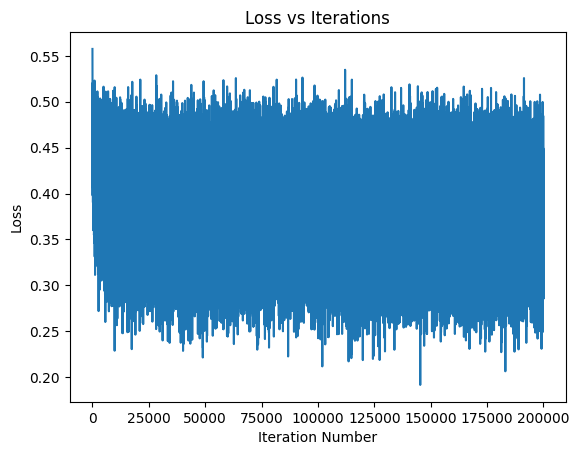

In [20]:
plt.plot(step_x, loss_y)
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.title("Loss vs Iterations");

## Experiment 3: The effect of extreme initial `Parameters` + `tanh()` saturation on model performance

Run experiment 2 first to retrieve the final value of parameter `h` after training session.

Play with the inital values for the model `Parameters`, perform a train loop and observe the graphs below to analyse the effect of the initial values on the final logits computed by the network and how it effects gradient descent. 

Note iteration 0's loss on each run.


In [21]:
params.h.shape

torch.Size([32, 200])

In [22]:
params.h.view(-1)

tensor([ 0.0028, -0.0916, -0.0316,  ..., -0.9999, -0.0045,  0.1444],
       grad_fn=<ViewBackward0>)

In [23]:
params.h.view(-1).shape

torch.Size([6400])

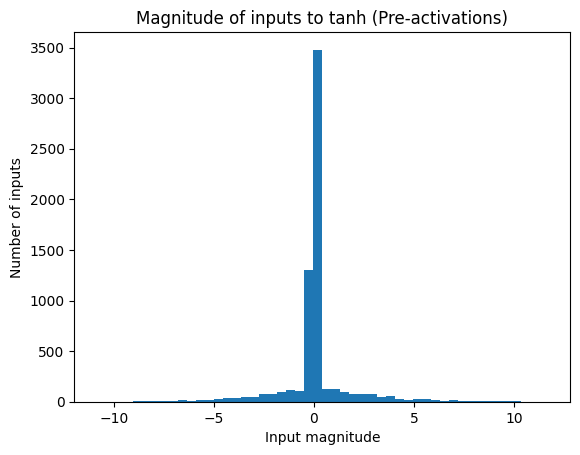

In [24]:
plt.hist(params.pre_acts.view(-1).tolist(), 50)
plt.title("Magnitude of inputs to tanh (Pre-activations)")
plt.xlabel("Input magnitude")
plt.ylabel("Number of inputs");

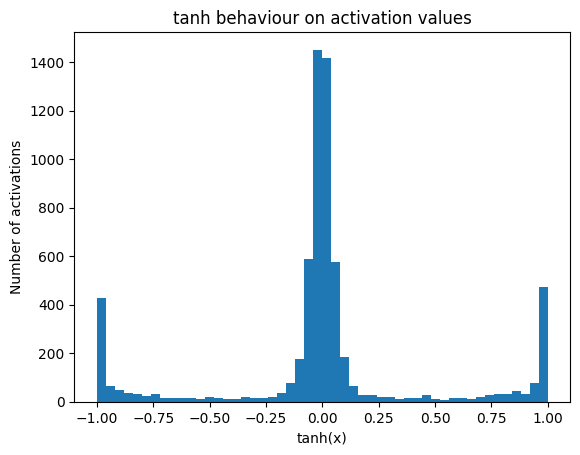

In [25]:
plt.hist(params.h.view(-1).tolist(), 50)
plt.title("tanh behaviour on activation values")
plt.xlabel("tanh(x)")
plt.ylabel("Number of activations");

### Reminder


| Object                     | Shape dimension     | Represents                                           |
| -------------------------- | ---------------     | ---------------------------------------------------- |
| Column in `h`              | `hidden_layer_size`   | a hidden neuron’s output (activation)                |
| Row in `W2`                | `hidden_layer_size`   | weights *from* a hidden neuron *to* all output chars |
| Column in `probs`          | `vocab_size`        | the score/probability of each output character       |


If we have a column full of white points, that neuron is dead because it is not propapating gradients backwards and will never learn. This brings down the training efficiency of the model.


We want the tanh activations to be within the middle curved areas of the region so that the gradients do not get destroyed.

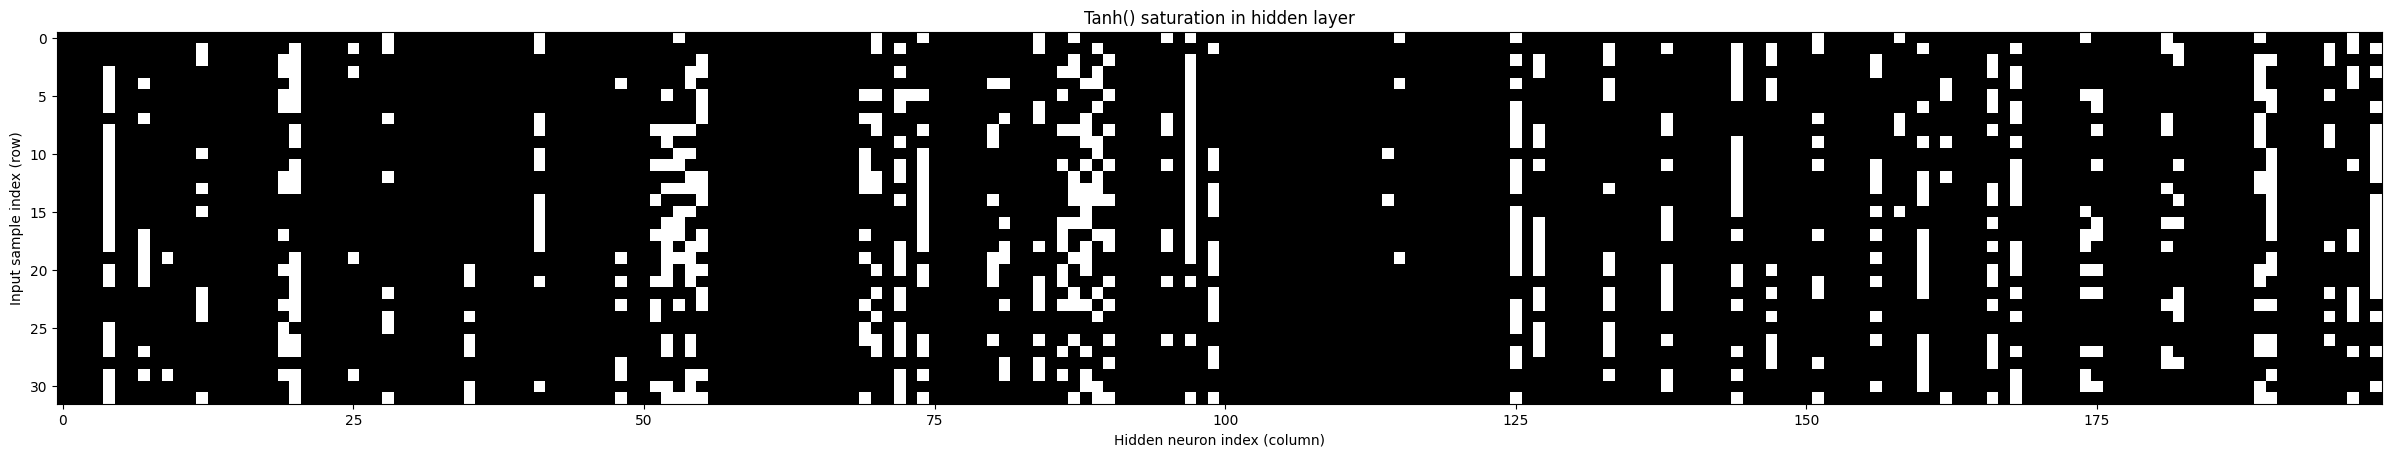

In [26]:
plt.figure(figsize=(30, 10))

# ? Black denotes True cases. White denotes False cases.
# * Ideally, we want the plots to be 100% black.
plt.imshow(params.h.abs() > 0.99, cmap="gray", interpolation="nearest")
plt.title("Tanh() saturation in hidden layer")
plt.xlabel("Hidden neuron index (column)")
plt.ylabel("Input sample index (row)");

1.4